In [7]:
import os.path
if  not os.path.isfile("OPT_helper.py"):
    !wget https://github.com/deeplearning-itba/optimizadores/raw/master/OPT_helper.py

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


/home/cselmo/miniconda3/envs/NLP/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  del sys.path[0]
/home/cselmo/miniconda3/envs/NLP/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  


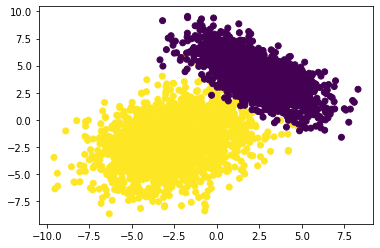

In [7]:
%load_ext autoreload
%autoreload 2
from IPython.display import YouTubeVideo
from sklearn.model_selection import train_test_split
import os.path
import keras
import numpy as np
from matplotlib import pyplot as plt
import OPT_helper
from sklearn.model_selection import train_test_split
from OPT_helper import make_animation
np.random.seed(432)
X=np.vstack([np.random.multivariate_normal([-2.5,-2], [[2,5],[5,1]], 2000),
             np.random.multivariate_normal([2.5,4], [[2,-3],[-3,2]], 2000)])
y=np.hstack([np.ones(2000),
             np.zeros(2000)])
#X=df[['Peso','Altura']].values
#y=df['Genero'].values
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42,shuffle=True)
plt.scatter(X[:,0],X[:,1],c=y)
plt.show()

In [2]:
y_test

array([1., 0., 1., ..., 0., 0., 0.])

# Adam

- También calcula learning rates adaptativos para cada parámetro.
- Es como RMSProp, pero agrega momento.

$$ m_t=\beta_1  m_{t-1} + (1-\beta_1)g_t $$
$$ v_t=\beta_2  v_{t-1} + (1-\beta_2)g^2_t $$

$m_t$ es el momento de primer orden (media) y $v_t$ es el momento de segundo orden. $v_t$ es exáctamente lo mismo que $E[g^2]_t$ en RMSProp.

siendo que $m_t$ y $v_t$ se inicializan en cero, la estimación de los momentos tendrá sesgo hacia el cero, por lo que se aplican la siguiente normalizaciones:

$$m'_t=\frac{m_t}{1-\beta_1^t}$$
$$v'_t=\frac{v_t}{1-\beta_2^t}$$

Si combinamos las tecnicas, utilizando $m_t$ como en SGD y $v_t$ como en RMSProp, nos queda la regla:

$$\Delta \vec W_{t+1}=-\frac{\eta}{\sqrt{v_t}+\epsilon} \cdotp m'_t$$

Los autores recomiendan $\beta_1=0.9$, $\beta_2=0.999$ y $\epsilon=1e-8$.  
En la práctica es el más usado y suele ser la primera opción.

# Red Neuronal de 1 capa

In [3]:
# Esta función recibe un modelo y devuelve los pesos que se quieren loggear
def get_weights(model):
    weights=list()
    for layer in model.layers[0:]:
        weights.append([layer.get_weights()[1][0],layer.get_weights()[0][0][0],layer.get_weights()[0][1][0]])
    return weights
def set_weights(model,w0,w1,w2):
    weights=model.layers[0].get_weights()
    weights[0][0][0]=w1
    weights[0][1][0]=w2
    weights[1][0]=w0
    model.layers[0].set_weights(weights)
def reset_weights(model):
    weights=model.layers[-1].get_weights()
    weights[0][0]=weights[0][0]*0
    model.layers[-1].set_weights(weights)


Epoch 00012: ReduceLROnPlateau reducing learning rate to 0.05.

Epoch 00022: ReduceLROnPlateau reducing learning rate to 0.010000000149011612.

Epoch 00032: ReduceLROnPlateau reducing learning rate to 0.0019999999552965165.
Restoring model weights from the end of the best epoch

Epoch 00042: ReduceLROnPlateau reducing learning rate to 0.0003999999724328518.


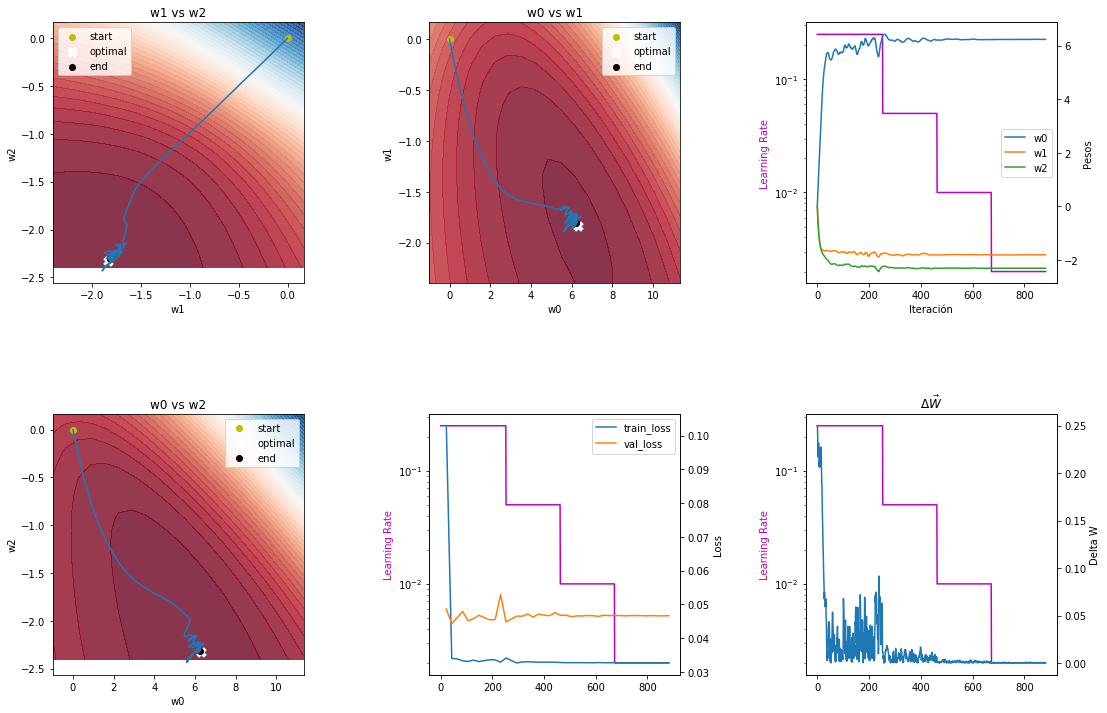

Epoch 00042: early stopping


In [5]:
from keras.models import Sequential
from keras.layers import Dense, Flatten
from keras import optimizers
from keras.callbacks import ModelCheckpoint,EarlyStopping, ReduceLROnPlateau
model = Sequential()
model.add(Dense(1, input_shape=x_train.shape[1:],activation='sigmoid', kernel_initializer='normal', name='salida'))
optimizer = optimizers.Adam(lr=0.25,
                               epsilon=1e-8, 
                               decay=0.0)
model.compile(loss = 'binary_crossentropy', optimizer=optimizer)
earlyStopping=EarlyStopping(monitor='val_loss', 
                            min_delta=0, 
                            patience=40, verbose=1, restore_best_weights=True)
reduceLR=ReduceLROnPlateau(monitor='val_loss', 
                           factor=0.2, 
                           patience=10, 
                           verbose=1, 
                           min_delta=0, 
                           cooldown=0, min_lr=0)
logWeights=OPT_helper.log_weights(get_weights,
                                  set_weights,
                                  surface_filename="./surface.pck",
                                  w1_range=[-2.4,0.3],
                                  w2_range=[-2.4,0.3],
                                  w0_range=[-1,12],
                                  n_points=20,
                                  w1_opt=-1.8372542,
                                  w2_opt=-2.325091,
                                  w0_opt=6.3067813,
                                  plotloss_data=(x_train, y_train))

history=model.fit(x_train, 
          y_train ,
          epochs=200,
          batch_size=128, 
          verbose=0, 
          validation_data=(x_test, y_test), 
          callbacks=[logWeights, earlyStopping, reduceLR])

In [9]:
get_weights(model)

[[9.8388405, -1.7412237, -2.0013444]]

No handles with labels found to put in legend.
No handles with labels found to put in legend.


799

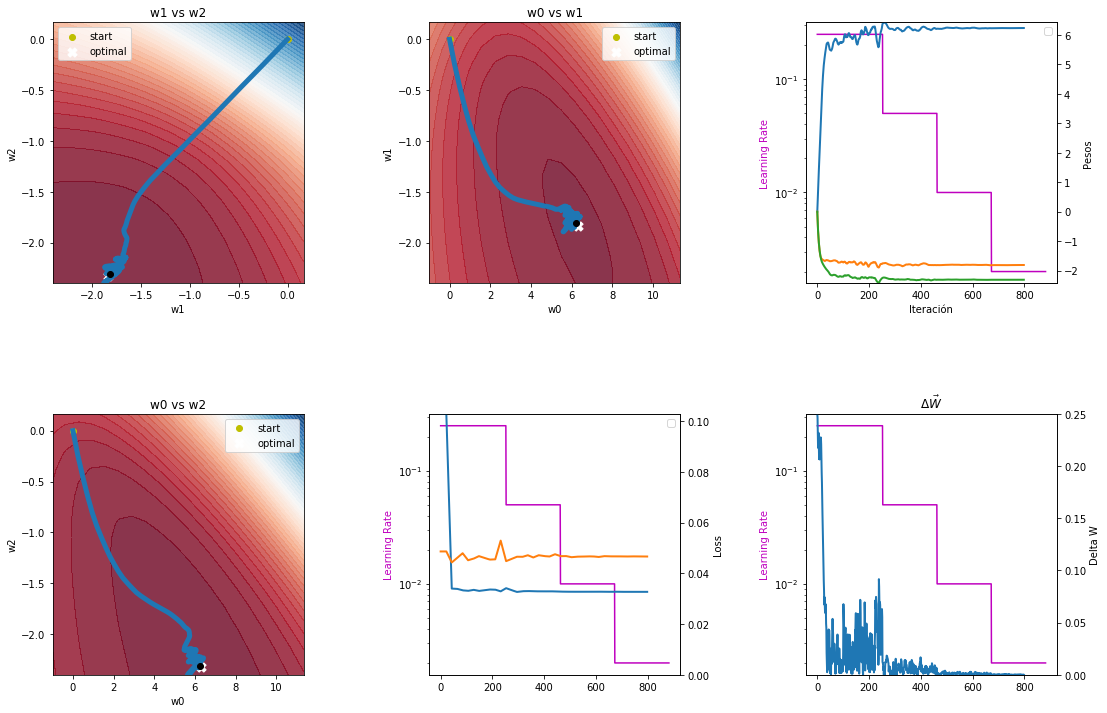

In [8]:
make_animation(output_filename="Adam.mp4",surface_filename="surface.pck",logWeights=logWeights,max_frames=800)